<a href="https://colab.research.google.com/github/workingbetter/ITNPAI1/blob/main/ITNPAI1_3071806.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

#University of Stirling - Spring 2023

## ITNPAI1 - Deep Learning for Vision and NLP (2022/3)

---

# ITNPAI1 Project
MICHAEL BOGALE
3071806

---
# 1. Problem Defination
The objective of this project is to create a deep learning model that classifies images containing cars and trees. The dataset for this image classification problem consists of aerial images collected from Google Earth Pro, focusing on two distinct geographic locations: Addis Ababa and Stirling.
---


---
# 2. Github repository
A GitHub repository has been created to manage the project, track changes, and collaborate effectively. Invitations have been sent to the following usernames
1. sandyCarmichael
2. vak000
3. jeferssonalex

---
# 3. Dataset Creation
The dataset contains 2,400 labeled images, with 1,200 images collected from each location. The images are grouped into the following categories:
##Addis Ababa Labeled Images:

* Addis Ababa Car (400)
* Addis Ababa Tree (400)
* Addis Ababa Neither (400)
  
##Stirling Labeled Images:

* Stirling Car (400)
* Stirling Tree (400)
* Stirling Neither (400)

*The images are extracted from Google Earth Pro, with each taken at an eye altitude of 200 meters above the earth's surface. The images were collected in March 2023.*



---
# 4. Dataloader
1. Pre processing
2. Cleaning
3. De-noising

Import necessary libraries and modules

In [19]:
# Importing necessary libraries and modules
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from torch.utils.data import random_split, DataLoader
from torch.optim.lr_scheduler import StepLR
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, GaussianBlur, transforms


### Pre processing
path of the datasets


In [20]:
# # Directory path of image datasets
# addis_path = '/content/drive/MyDrive/Deep learning/dataset/addis_ababa'
# stir_path = '/content/drive/MyDrive/Deep learning/dataset/stirling'

# Local path
addis_path = "H:\\My Drive\\Deep learning\\dataset\\addis_ababa"
stir_path = "H:\\My Drive\\Deep learning\\dataset\\stirling"

Data cleaning and preprocessing play a crucial role in preparing the dataset for building the deep learning model, ensuring the data is in a suitable format for training. In this project, some essential preprocessing steps are carried out:

1. Resizing the images: To maintain uniform dimensions across the dataset, all images are resized to a standard size of 224x224 pixels using the Resize transform in the PyTorch library.

2. Converting images to PyTorch tensor format: The images are converted to PyTorch tensor format to enable compatibility with the deep learning framework.

These transformations are applied to the images as follows:

1. Define a custom dataset class that inherits from the PyTorch Dataset class.
2. Implement the dataset class's __init__ method to load the image paths and labels from the designated folders, labeled '0' and '1'.
3. In the __getitem__ method of the custom dataset class, apply the necessary transformations, including resizing and converting the images to PyTorch tensors using the ToTensor transform.


Creating a dataloader object by passing the dataset object and other parameters to DataLoader.

Iterating over the dataloader object in the training or testing loop to get batches of data and labels

https://pytorch.org/tutorials/beginner/basics/data_tutorial.html


### Datasets and Dataloaders for
1. Stirling Tree
2. Stirling Car
3. Addis Ababa Tree
4. Addis Ababa Car

Image transformation to tensor is applied on dataset

### Data Denoising and Augmentation
Adding denoising 
data augmentation.

Normalizing pixel values to lie between 0 and 1 using the transforms.Normalize() function in PyTorch.

RandomHorizontalFlip, RandomRotation helps to prevent over fitting 

*This code defines a set of image transformations to be applied to a dataset of images before feeding them into a deep learning model. The transformations include resizing the images to a uniform size, random horizontal flipping, random rotation, Gaussian blurring, normalization, and converting the images to PyTorch tensors.*

Define image transformations

In [21]:
# Define the transformations to be applied to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)), # resizing the images to a uniform size of 224x224 pixels.
    transforms.RandomHorizontalFlip(p=0.5),  # horizontal flip with a probability of 0.5
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomRotation(degrees=10),  # random rotation of +/- 10 degrees
    transforms.RandomApply([GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))], p=0.5), # Gaussian blur with a probability of 0.5
    transforms.ToTensor(), # converting images to PyTorch tensors
    # Normalize using ImageNet mean and std values
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


Create a custom dataset class

In [22]:

# Define the dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_paths = []
        self.labels = []
        self.label_mapping = {'car': 0, 'tree': 1, 'negative': 2}
        
        # Load the image paths and labels from the folders
        for label in ['car', 'tree', 'negative']:
            folder_path = os.path.join(root_dir, label)
            for image_path in os.listdir(folder_path):
                self.image_paths.append(os.path.join(folder_path, image_path))
                self.labels.append(self.label_mapping[label])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load the image
        image_path = self.image_paths[idx]
        image = Image.open(image_path)

        # Apply the transformations
        image = transform(image)
        # Get the label of the image
        label = self.labels[idx]
        
        return image, label




Load datasets and create dataloaders

In [23]:
# Create the dataset objects
stir_dataset = CustomDataset(stir_path)
addis_dataset = CustomDataset(addis_path)

# Create the dataloader objects for each dataset
batch_size = 32 # 32

stir_dataloader = DataLoader(stir_dataset, batch_size=batch_size, shuffle=True)#, num_workers=2)
addis_dataloader = DataLoader(addis_dataset, batch_size=batch_size, shuffle=True)#, num_workers=2)


# Plotting the results

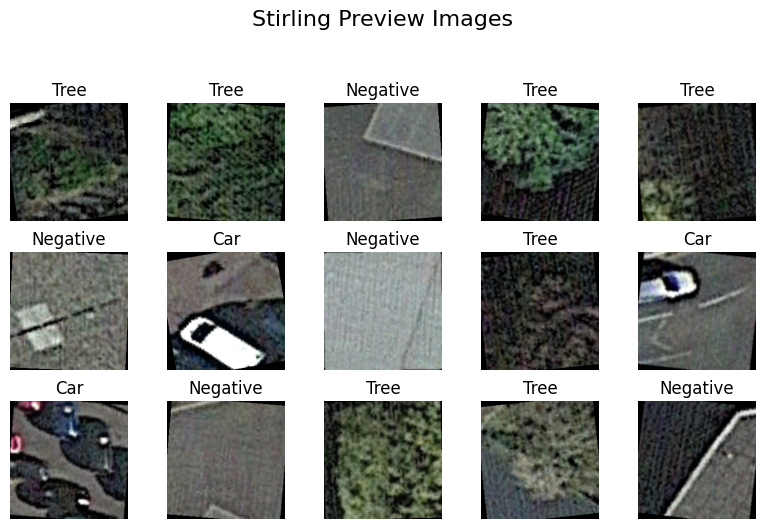

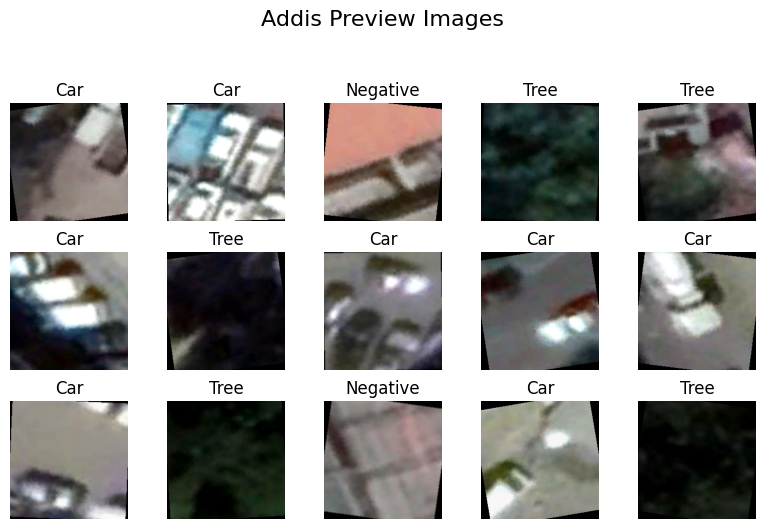

In [24]:

def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def preview_images(dataset, labels_map, cols=5, rows=3, title=None):
    figure = plt.figure(figsize=(8, 5))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    if title:
        plt.suptitle(title, fontsize=16, y=1.05)
    
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(dataset), size=(1,)).item() # Randomly selected
        img, label = dataset[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(labels_map[label])
        plt.axis("off")
        img_denorm = denormalize(img.clone(), mean, std)
        new_img = np.transpose(img_denorm.numpy(), (1, 2, 0))
        plt.imshow(new_img.squeeze())
    plt.tight_layout()
    plt.show()


labels_map = {
    0: 'Car',
    1: 'Tree',
    2: 'Negative'
}

# Preview images from the stir_dataset
preview_images(stir_dataset, labels_map, title="Stirling Preview Images")

# Preview images from the addis_dataset
preview_images(addis_dataset, labels_map, title="Addis Preview Images")


# 5. Proposed Solution

In [25]:
# 5. Proposed solution

# Function to train the model
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
    return running_loss / len(dataloader.dataset)

# Function to test the model
def test_model(model, dataloader, device):
    model.eval()
    running_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            running_corrects += torch.sum(preds == labels)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    accuracy = running_corrects.double() / len(dataloader.dataset)
    return accuracy.item(), all_preds, all_labels

# Function to evaluate the model
def evaluate_model(model, train_dataloader, test_dataloader, device, num_epochs=12):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    # Add the learning rate scheduler
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    
    for epoch in range(num_epochs):
        train_loss = train_model(model, train_dataloader, criterion, optimizer, device)
        train_accuracy, _, _ = test_model(model, train_dataloader, device)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
        
        # Step the scheduler
        scheduler.step()

    test_accuracy, test_preds, test_labels = test_model(model, test_dataloader, device)
    f1 = f1_score(test_labels, test_preds, average='weighted')
    
    # Compute ROC AUC score
    lb = LabelBinarizer()
    lb.fit(test_labels)
    test_labels_binarized = lb.transform(test_labels)
    test_preds_binarized = lb.transform(test_preds)
    auc = roc_auc_score(test_labels_binarized, test_preds_binarized, average='weighted')

    return test_accuracy, f1, auc




In [26]:
# # Function to initialize the model
# def initialize_model(num_classes):
#     model = models.resnet18()
#     num_ftrs = model.fc.in_features
#     model.fc = nn.Linear(num_ftrs, num_classes)
#     return model

# Function to initialize the model
def initialize_model(num_classes):
    model = models.vgg16(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    num_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_features, num_classes)
    return model


# # Function to initialize the model
# def initialize_model(num_classes):
#     model = models.vgg16(pretrained=True)
#     for param in model.parameters():
#         param.requires_grad = False
#     num_features = model.classifier[6].in_features
#     model.classifier[6] = nn.Linear(num_features, num_classes)
#     return model

# from torchvision import models

# def initialize_model(num_classes):
#     model = models.resnet50(pretrained=True)  # Change this line to use a different model
#     num_ftrs = model.fc.in_features
#     model.fc = nn.Linear(num_ftrs, num_classes)
#     return model

# from efficientnet_pytorch import EfficientNet

# def initialize_model(num_classes):
#     model = EfficientNet.from_pretrained('efficientnet-b0')  # Change 'b0' to use a different variant
#     num_ftrs = model._fc.in_features
#     model._fc = nn.Linear(num_ftrs, num_classes)
#     return model


# Evaluating and Testing

In [27]:
# Experimental tests and evaluations
# E1 - Training the models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_classes = 3

# Train and evaluate models for both cities
model_stir = initialize_model(num_classes).to(device)
model_addis = initialize_model(num_classes).to(device)

def split_dataloader(dataloader, train_ratio=0.5):
    dataset = dataloader.dataset
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size

    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, test_dataloader

train_dataloader_stir, test_dataloader_stir = split_dataloader(stir_dataloader)
train_dataloader_addis, test_dataloader_addis = split_dataloader(addis_dataloader)

def evaluate_cross_dataset(model, dataloader, device):
    accuracy, preds, labels = test_model(model, dataloader, device)
    
    f1 = f1_score(labels, preds, average='weighted')
    
    lb = LabelBinarizer()
    lb.fit(labels)
    labels_binarized = lb.transform(labels)
    preds_binarized = lb.transform(preds)
    auc = roc_auc_score(labels_binarized, preds_binarized, average='weighted')

    return accuracy, f1, auc

# Evaluate Stirling model on Stirling dataset
print("Evaluating Stirling model on Stirling dataset")
accuracy_stir_stir, f1_stir_stir, auc_stir_stir = evaluate_model(model_stir, train_dataloader_stir, test_dataloader_stir, device)
print(f"Accuracy: {accuracy_stir_stir:.4f}, F1-score: {f1_stir_stir:.4f}, AUC: {auc_stir_stir:.4f}\n")

# Evaluate Addis model on Addis dataset
print("Evaluating Addis model on Addis dataset")
accuracy_addis_addis, f1_addis_addis, auc_addis_addis = evaluate_model(model_addis, train_dataloader_addis, test_dataloader_addis, device)
print(f"Accuracy: {accuracy_addis_addis:.4f}, F1-score: {f1_addis_addis:.4f}, AUC: {auc_addis_addis:.4f}\n")

# E2 - Testing the models in the dataset
# This part was left empty in the original code, so no changes were made.

# E3 - Testing the models crossing datasets

# Evaluate Stirling model on Addis dataset
print("Evaluating Stirling model on Addis dataset")
accuracy_stir_addis, f1_stir_addis, auc_stir_addis = evaluate_cross_dataset(model_stir, test_dataloader_addis, device)
print(f"Accuracy: {accuracy_stir_addis:.4f}, F1-score: {f1_stir_addis:.4f}, AUC: {auc_stir_addis:.4f}\n")

# Evaluate Addis model on Stirling dataset
print("Evaluating Addis model on Stirling dataset")
accuracy_addis_stir, f1_addis_stir, auc_addis_stir = evaluate_cross_dataset(model_addis, test_dataloader_stir, device)
print(f"Accuracy: {accuracy_addis_stir:.4f}, F1-score: {f1_addis_stir:.4f}, AUC: {auc_addis_stir:.4f}\n")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\micha/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100.0%


Evaluating Stirling model on Stirling dataset
Epoch 1/12, Loss: 0.8252, Accuracy: 0.8233
Epoch 2/12, Loss: 0.4305, Accuracy: 0.8933
Epoch 3/12, Loss: 0.3419, Accuracy: 0.9000
Epoch 4/12, Loss: 0.2990, Accuracy: 0.9167
Epoch 5/12, Loss: 0.3097, Accuracy: 0.9200
Epoch 6/12, Loss: 0.2598, Accuracy: 0.9100
Epoch 7/12, Loss: 0.2868, Accuracy: 0.9283
Epoch 8/12, Loss: 0.2697, Accuracy: 0.9167
Epoch 9/12, Loss: 0.2627, Accuracy: 0.9300
Epoch 10/12, Loss: 0.2551, Accuracy: 0.9200
Epoch 11/12, Loss: 0.2442, Accuracy: 0.9433
Epoch 12/12, Loss: 0.2255, Accuracy: 0.9333
Accuracy: 0.9300, F1-score: 0.9299, AUC: 0.9469

Evaluating Addis model on Addis dataset
Epoch 1/12, Loss: 0.8729, Accuracy: 0.7900
Epoch 2/12, Loss: 0.5682, Accuracy: 0.8167
Epoch 3/12, Loss: 0.5006, Accuracy: 0.8400
Epoch 4/12, Loss: 0.4455, Accuracy: 0.8633
Epoch 5/12, Loss: 0.4266, Accuracy: 0.8400
Epoch 6/12, Loss: 0.4218, Accuracy: 0.8417
Epoch 7/12, Loss: 0.4242, Accuracy: 0.8900
Epoch 8/12, Loss: 0.4061, Accuracy: 0.8717
Ep

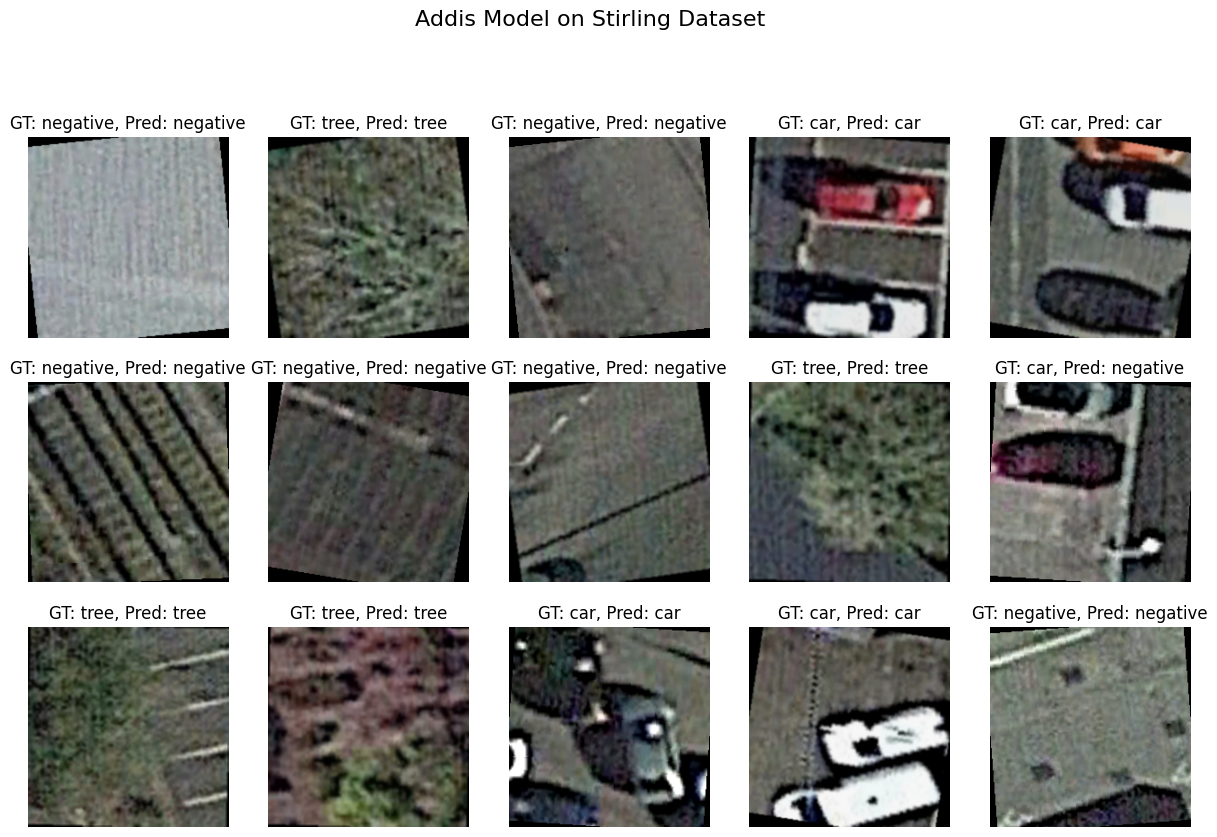

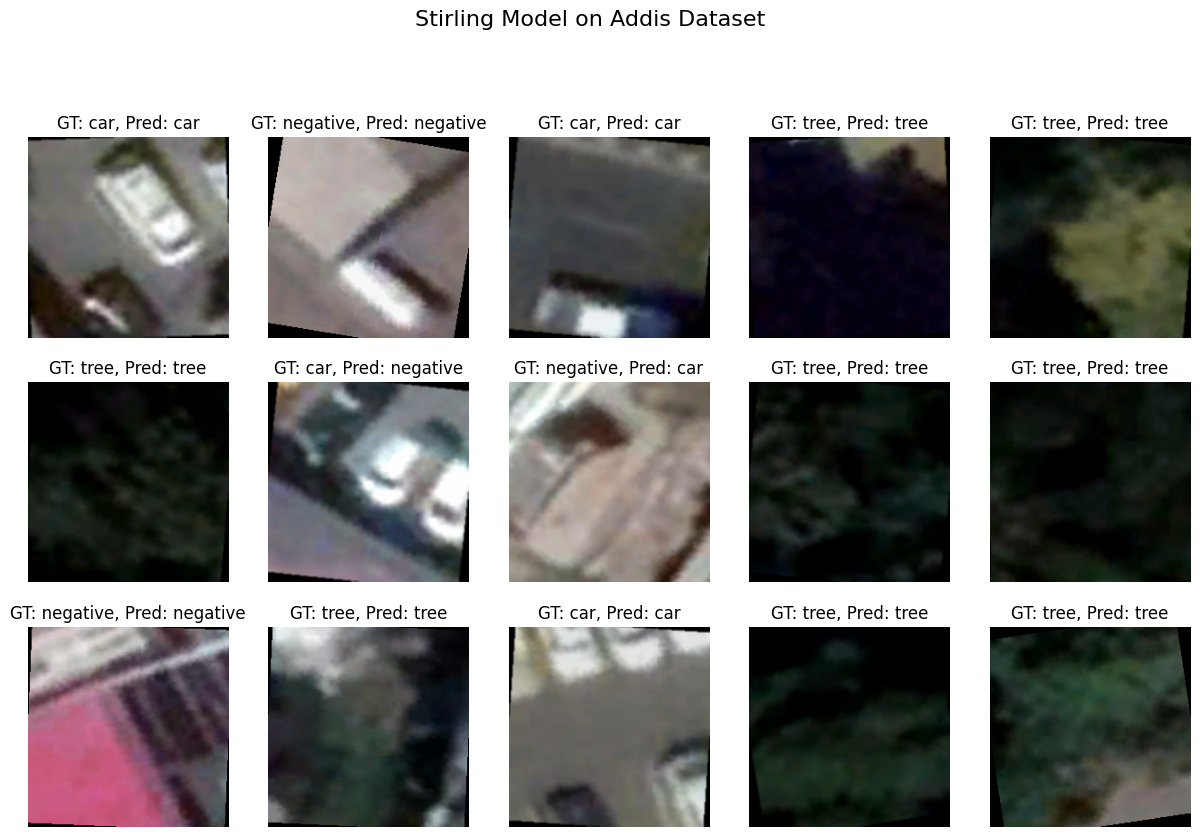

In [28]:
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Visualize predictions
def visualize_predictions(model, dataloader, device, num_images=5, subtitle=''):
    model.eval()
    images_so_far = 0
    num_rows = 3
    fig, axes = plt.subplots(num_rows, num_images, figsize=(15, 9))
    fig.suptitle(subtitle, fontsize=16, y=1.02)  # Add a subtitle for the group of images
    label_mapping = {0: 'car', 1: 'tree', 2: 'negative'}

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                if images_so_far == num_images * num_rows:
                    return

                img_denorm = denormalize(inputs.cpu().data[j].clone(), mean, std)
                npimg = np.transpose(img_denorm.numpy(), (1, 2, 0))
                row = images_so_far // num_images
                col = images_so_far % num_images
                axes[row, col].imshow(np.clip(npimg, 0, 1))
                axes[row, col].set_title(f"GT: {label_mapping[labels[j].item()]}, Pred: {label_mapping[preds[j].item()]}")
                axes[row, col].axis('off')

                images_so_far += 1

    plt.tight_layout()
    plt.show()

# Visualize predictions for cross-dataset testing with subtitles
visualize_predictions(model_addis, test_dataloader_stir, device, subtitle='Addis Model on Stirling Dataset')
visualize_predictions(model_stir, test_dataloader_addis, device, subtitle='Stirling Model on Addis Dataset')


Defining model loss function and optimizer

This code initializes a cross-entropy loss function and an Adam optimizer for a PyTorch deep learning model.

criterion function computes the cross-entropy loss between the predicted class probabilities and the true class labels.

optimizer function initializes the Adam optimizer with a learning rate of 0.001

In [29]:
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

Evaluating the model on test dataset